# Reinforcement Learning: Zero to Hero - Part 13/17

**Cells 201-220 of 291**



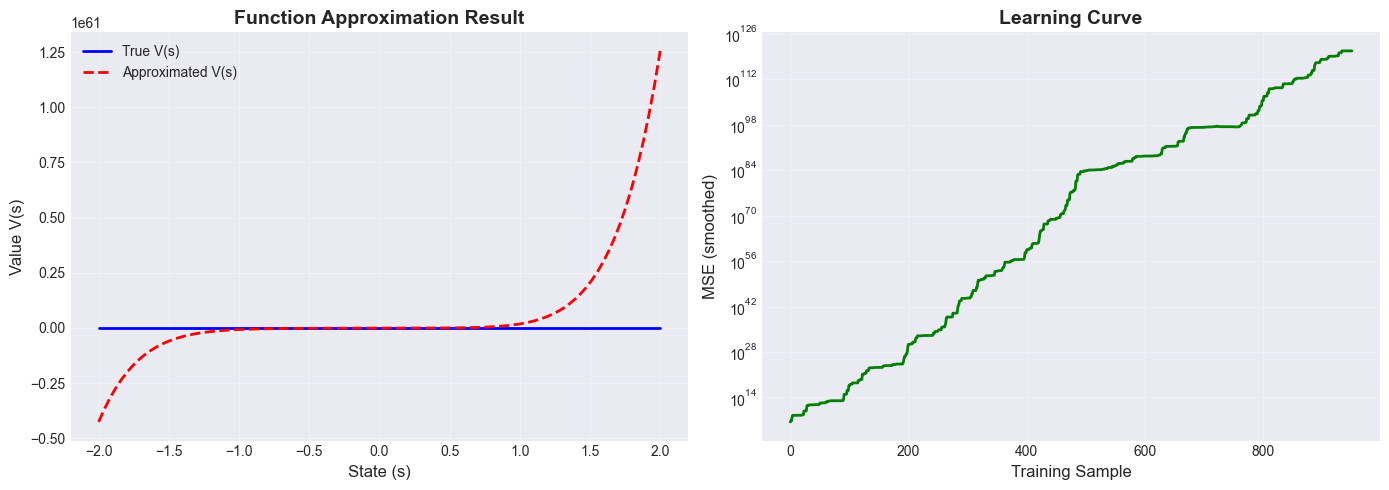

📊 Key Points:
   - Function approximation allows handling continuous/large state spaces
   - Linear approximation with good features can work well
   - Neural networks can learn features automatically (deep RL)
   - Trade-off: approximation error vs. generalization


In [108]:
# Visualize the approximation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: True vs Approximated function
ax1 = axes[0]
x_test = np.linspace(-2, 2, 100)
y_true = [true_value(x) for x in x_test]
y_approx = [approximator.predict([x]) for x in x_test]

ax1.plot(x_test, y_true, 'b-', linewidth=2, label='True V(s)')
ax1.plot(x_test, y_approx, 'r--', linewidth=2, label='Approximated V(s)')
ax1.set_xlabel('State (s)', fontsize=12)
ax1.set_ylabel('Value V(s)', fontsize=12)
ax1.set_title('Function Approximation Result', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Learning curve
ax2 = axes[1]
window = 50
smoothed_errors = np.convolve(errors, np.ones(window)/window, mode='valid')
ax2.plot(smoothed_errors, 'g-', linewidth=2)
ax2.set_xlabel('Training Sample', fontsize=12)
ax2.set_ylabel('MSE (smoothed)', fontsize=12)
ax2.set_title('Learning Curve', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print("📊 Key Points:")
print("   - Function approximation allows handling continuous/large state spaces")
print("   - Linear approximation with good features can work well")
print("   - Neural networks can learn features automatically (deep RL)")
print("   - Trade-off: approximation error vs. generalization")

<a id='advanced-policy'></a>
### Advanced Policy Methods

This section covers sophisticated techniques for policy optimization, including eligibility traces and trust region methods.

#### Eligibility Traces

**What are Eligibility Traces?**

Eligibility traces provide a mechanism to bridge the gap between Monte Carlo methods (which use complete returns) and TD methods (which bootstrap from single steps). They allow credit to be assigned to states visited in the recent past.

**The Idea:**

When we receive a reward, we want to update not just the immediately preceding state, but also states visited earlier that may have contributed to that reward. Eligibility traces keep track of which states are "eligible" for updates.

**Mathematical Formulation:**

For each state $s$, we maintain an eligibility trace $e_t(s)$:

$$e_t(s) = \begin{cases}
\gamma \lambda e_{t-1}(s) + 1 & \text{if } s = S_t \\
\gamma \lambda e_{t-1}(s) & \text{otherwise}
\end{cases}$$

where:
- $\gamma$ is the discount factor
- $\lambda \in [0, 1]$ is the trace decay parameter

**TD(λ) Update Rule:**

$$V(s) \leftarrow V(s) + \alpha \delta_t e_t(s)$$

where $\delta_t = R_{t+1} + \gamma V(S_{t+1}) - V(S_t)$ is the TD error.

**Special Cases:**

- $\lambda = 0$: TD(0) - only update the current state
- $\lambda = 1$: Equivalent to Monte Carlo (in episodic tasks)
- $0 < \lambda < 1$: Blend of TD and MC

**Benefits of Eligibility Traces:**

1. Faster credit assignment to earlier states
2. More efficient learning in many problems
3. Smooth interpolation between TD and MC
4. Can be combined with function approximation

#### Trust Region Policy Optimization (TRPO)

**The Problem with Standard Policy Gradients**

Standard policy gradient methods can be unstable because:
- Large policy updates can drastically change behavior
- Bad updates can be catastrophic and hard to recover from
- Step size selection is difficult

**TRPO's Solution: Constrained Optimization**

TRPO ensures stable learning by constraining how much the policy can change in each update.

**The Objective:**

Maximize the expected improvement while staying close to the old policy:

$$\max_{\theta} \mathbb{E}_{s \sim \rho_{\theta_{old}}, a \sim \pi_{\theta_{old}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} A^{\pi_{\theta_{old}}}(s, a) \right]$$

subject to:

$$\mathbb{E}_{s \sim \rho_{\theta_{old}}} \left[ D_{KL}(\pi_{\theta_{old}}(\cdot|s) \| \pi_\theta(\cdot|s)) \right] \leq \delta$$

where:
- $\pi_\theta$ is the new policy
- $\pi_{\theta_{old}}$ is the old policy
- $A^{\pi}(s, a)$ is the advantage function
- $D_{KL}$ is the KL divergence
- $\delta$ is the trust region size

**Key Components:**

**1. Surrogate Objective**

The ratio $\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}$ measures how much more/less likely an action is under the new policy.

**2. KL Divergence Constraint**

Ensures the new policy doesn't deviate too far from the old one:

$$D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}$$

**3. Natural Gradient**

TRPO uses the natural gradient, which accounts for the geometry of the policy space:

$$\theta_{new} = \theta_{old} + \sqrt{\frac{2\delta}{g^T F^{-1} g}} F^{-1} g$$

where $F$ is the Fisher information matrix and $g$ is the policy gradient.

**How TRPO Differs from Other Methods:**

| Method | Update Strategy | Stability |
|--------|----------------|----------|
| Vanilla PG | Fixed step size | Low |
| TRPO | KL constraint | High |
| PPO | Clipped objective | High |

**Advantages of TRPO:**
- Guaranteed monotonic improvement (in theory)
- More stable than vanilla policy gradients
- Works well with neural network policies

**Disadvantages:**
- Computationally expensive (requires computing Fisher matrix)
- Complex implementation
- PPO often achieves similar results with simpler implementation

<a id='specialized'></a>
### Specialized RL Techniques

This section covers advanced RL paradigms designed for specific challenging scenarios.

#### Hierarchical Reinforcement Learning

**The Problem:**

Many real-world tasks have natural hierarchical structure. For example, making coffee involves:
- High-level: Get cup → Fill with water → Add coffee → Heat
- Low-level: Each step involves many primitive actions

Flat RL struggles with such tasks due to:
- Long time horizons
- Sparse rewards
- Credit assignment over many steps

**Hierarchical RL Solution:**

Decompose the problem into multiple levels of abstraction:

```
High-Level Policy (Manager)
    ↓ selects subgoals
Mid-Level Policy (Sub-manager)
    ↓ selects options
Low-Level Policy (Worker)
    ↓ executes primitive actions
Environment
```

**Key Frameworks:**

**1. Options Framework**

An option $\omega$ consists of:
- Initiation set $I_\omega$: states where option can start
- Policy $\pi_\omega$: how to behave while option is active
- Termination condition $\beta_\omega$: when to stop

**2. Feudal Networks (FuN)**

- Manager sets goals in a learned goal space
- Worker tries to achieve goals
- Manager operates at lower temporal resolution

**3. MAXQ Decomposition**

- Decomposes value function hierarchically
- Each subtask has its own value function

**Benefits:**
- Temporal abstraction: reason over longer time scales
- Transfer: reuse low-level skills across tasks
- Exploration: structured exploration at multiple levels

#### Inverse Reinforcement Learning

**The Problem:**

In standard RL, we're given a reward function and learn a policy. But what if:
- The reward function is hard to specify?
- We have expert demonstrations but no reward signal?

**Inverse RL (IRL) flips the problem:**

Given expert demonstrations, learn the reward function that the expert is optimizing.

**Formal Definition:**

Given:
- MDP without reward: $(S, A, P, \gamma)$
- Expert demonstrations: $\{\tau_1, \tau_2, ..., \tau_n\}$

Find:
- Reward function $R(s, a)$ such that expert policy is optimal

**Key Approaches:**

**1. Maximum Entropy IRL**

Assume expert is noisily optimal with maximum entropy:

$$P(\tau) \propto \exp(R(\tau))$$

**2. Generative Adversarial Imitation Learning (GAIL)**

- Generator: policy trying to match expert
- Discriminator: distinguishes expert from generated trajectories
- Reward = discriminator output

**Applications:**
- Learning from human demonstrations
- Autonomous driving from human drivers
- Robot manipulation from teleoperation

#### Partial Observability

**The Problem:**

In many real-world scenarios, the agent cannot observe the full state:
- Robot with limited sensors
- Poker player who can't see opponents' cards
- Medical diagnosis with incomplete patient history

**Partially Observable MDP (POMDP):**

A POMDP extends an MDP with:
- Observation space $\Omega$
- Observation function $O(o|s, a)$: probability of observation given state and action

The agent receives observations $o \in \Omega$ instead of states $s \in S$.

**Challenges:**
- State is hidden: must infer from observations
- History matters: same observation can mean different things
- Belief tracking: maintain probability distribution over states

**Solutions:**

**1. Belief State Methods**

Maintain a belief $b(s) = P(s|h)$ over states given history $h$:

$$b'(s') = \frac{O(o|s',a) \sum_s P(s'|s,a) b(s)}{P(o|b,a)}$$

**2. Recurrent Neural Networks**

Use LSTM/GRU to maintain implicit belief state:
- Input: sequence of observations
- Hidden state: learned representation of history
- Output: action or value

**3. Attention Mechanisms**

- Transformer architectures for RL
- Attend to relevant parts of history
- Decision Transformer: RL as sequence modeling

In [109]:
# Simple demonstration of hierarchical RL concepts
import numpy as np
import matplotlib.pyplot as plt

class HierarchicalGridWorld:
    """A grid world with rooms to demonstrate hierarchical RL.
    
    The grid has 4 rooms connected by doorways.
    High-level: choose which room to go to
    Low-level: navigate within/between rooms
    """
    
    def __init__(self, size=11):
        self.size = size
        self.mid = size // 2
        
        # Define room centers
        self.rooms = {
            0: (self.mid // 2, self.mid // 2),           # Bottom-left
            1: (self.mid + self.mid // 2, self.mid // 2), # Bottom-right
            2: (self.mid // 2, self.mid + self.mid // 2), # Top-left
            3: (self.mid + self.mid // 2, self.mid + self.mid // 2)  # Top-right
        }
        
        # Define doorways (passages between rooms)
        self.doorways = [
            (self.mid, self.mid // 2),      # Between rooms 0 and 1
            (self.mid, self.mid + self.mid // 2),  # Between rooms 2 and 3
            (self.mid // 2, self.mid),      # Between rooms 0 and 2
            (self.mid + self.mid // 2, self.mid)   # Between rooms 1 and 3
        ]
        
        self.state = None
        self.goal = None
        self.reset()
    
    def reset(self):
        # Start in room 0, goal in room 3
        self.state = self.rooms[0]
        self.goal = self.rooms[3]
        return self.state
    
    def get_current_room(self):
        """Determine which room the agent is in."""
        x, y = self.state
        if x < self.mid and y < self.mid:
            return 0
        elif x >= self.mid and y < self.mid:
            return 1
        elif x < self.mid and y >= self.mid:
            return 2
        else:
            return 3
    
    def step(self, action):
        """Take a primitive action (0=up, 1=right, 2=down, 3=left)."""
        x, y = self.state
        
        # Calculate new position
        if action == 0 and y < self.size - 1:
            new_y = y + 1
            new_x = x
        elif action == 1 and x < self.size - 1:
            new_x = x + 1
            new_y = y
        elif action == 2 and y > 0:
            new_y = y - 1
            new_x = x
        elif action == 3 and x > 0:
            new_x = x - 1
            new_y = y
        else:
            new_x, new_y = x, y
        
        # Check for walls (can only cross at doorways)
        crosses_vertical = (x < self.mid and new_x >= self.mid) or (x >= self.mid and new_x < self.mid)
        crosses_horizontal = (y < self.mid and new_y >= self.mid) or (y >= self.mid and new_y < self.mid)
        
        if crosses_vertical and (x, y) not in self.doorways and (new_x, new_y) not in self.doorways:
            new_x = x  # Blocked by wall
        if crosses_horizontal and (x, y) not in self.doorways and (new_x, new_y) not in self.doorways:
            new_y = y  # Blocked by wall
        
        self.state = (new_x, new_y)
        done = self.state == self.goal
        reward = 10.0 if done else -0.1
        
        return self.state, reward, done


# Demonstrate the environment
print("Hierarchical Grid World Environment")
print("="*50)
print("This environment has 4 rooms connected by doorways.")
print("A hierarchical agent would:")
print("  - High-level: Plan which rooms to visit")
print("  - Low-level: Navigate to doorways and within rooms")

env = HierarchicalGridWorld()
print(f"Grid size: {env.size}x{env.size}")
print(f"Start: {env.state} (Room {env.get_current_room()})")
print(f"Goal: {env.goal} (Room 3)")
print(f"Doorways: {env.doorways}")

Hierarchical Grid World Environment
This environment has 4 rooms connected by doorways.
A hierarchical agent would:
  - High-level: Plan which rooms to visit
  - Low-level: Navigate to doorways and within rooms
Grid size: 11x11
Start: (2, 2) (Room 0)
Goal: (7, 7) (Room 3)
Doorways: [(5, 2), (5, 7), (2, 5), (7, 5)]


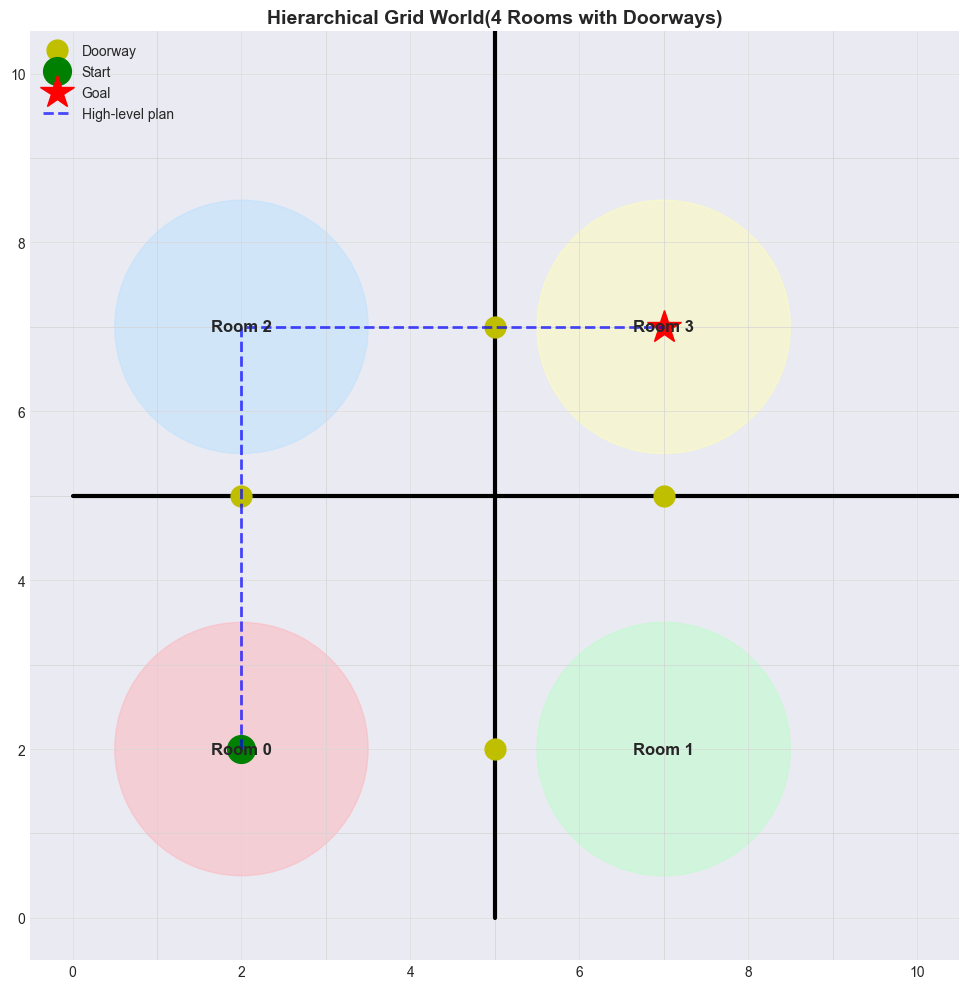

📊 Hierarchical Decomposition:
   High-level policy: Room 0 → Room 2 → Room 3
   Low-level skills: Navigate to doorway, cross doorway, navigate to goal
   Benefits:
   - Temporal abstraction: plan over rooms, not individual steps
   - Reusable skills: 'go to doorway' works in any room
   - Efficient exploration: explore at multiple levels


In [110]:
# Visualize the hierarchical grid world
fig, ax = plt.subplots(figsize=(10, 10))

# Draw grid
for i in range(env.size + 1):
    ax.axhline(y=i, color='lightgray', linewidth=0.5)
    ax.axvline(x=i, color='lightgray', linewidth=0.5)

# Draw walls (thick lines at room boundaries)
mid = env.mid
# Vertical wall
ax.plot([mid, mid], [0, mid], 'k-', linewidth=3)
ax.plot([mid, mid], [mid, env.size], 'k-', linewidth=3)
# Horizontal wall
ax.plot([0, mid], [mid, mid], 'k-', linewidth=3)
ax.plot([mid, env.size], [mid, mid], 'k-', linewidth=3)

# Draw doorways (gaps in walls)
for dx, dy in env.doorways:
    ax.plot(dx, dy, 'yo', markersize=15, label='Doorway' if (dx, dy) == env.doorways[0] else '')

# Draw room centers and labels
room_colors = ['#FFB3BA', '#BAFFC9', '#BAE1FF', '#FFFFBA']
for room_id, (rx, ry) in env.rooms.items():
    ax.add_patch(plt.Circle((rx, ry), 1.5, color=room_colors[room_id], alpha=0.5))
    ax.text(rx, ry, f'Room {room_id}', ha='center', va='center', fontsize=12, fontweight='bold')

# Draw start and goal
ax.plot(env.rooms[0][0], env.rooms[0][1], 'go', markersize=20, label='Start')
ax.plot(env.goal[0], env.goal[1], 'r*', markersize=25, label='Goal')

# Draw hierarchical plan
plan = [env.rooms[0], env.doorways[2], env.rooms[2], env.doorways[1], env.rooms[3]]
plan_x = [p[0] for p in plan]
plan_y = [p[1] for p in plan]
ax.plot(plan_x, plan_y, 'b--', linewidth=2, alpha=0.7, label='High-level plan')

ax.set_xlim(-0.5, env.size - 0.5)
ax.set_ylim(-0.5, env.size - 0.5)
ax.set_aspect('equal')
ax.set_title('Hierarchical Grid World(4 Rooms with Doorways)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("📊 Hierarchical Decomposition:")
print("   High-level policy: Room 0 → Room 2 → Room 3")
print("   Low-level skills: Navigate to doorway, cross doorway, navigate to goal")
print("   Benefits:")
print("   - Temporal abstraction: plan over rooms, not individual steps")
print("   - Reusable skills: 'go to doorway' works in any room")
print("   - Efficient exploration: explore at multiple levels")

### Section 3 Summary

In this section, we covered advanced topics that extend the foundational RL algorithms:

**Reward Engineering**
- Reward shaping can dramatically speed up learning
- Potential-based shaping preserves optimal policies
- Common challenges: sparse rewards, reward hacking, credit assignment

**Scaling and Generalization**
- Function approximation handles high-dimensional spaces
- Transfer learning leverages knowledge across tasks
- Domain randomization and meta-learning improve generalization

**Advanced Policy Methods**
- Eligibility traces bridge TD and Monte Carlo methods
- TRPO provides stable policy updates via trust regions
- KL divergence constraints prevent catastrophic updates

**Specialized Techniques**
- Hierarchical RL decomposes complex tasks into subtasks
- Inverse RL learns reward functions from demonstrations
- POMDPs handle partial observability with belief states or RNNs

**Next Steps:**

In the following sections, we'll see how these concepts are applied in real-world applications and explore current research trends in reinforcement learning!

<a id='section4'></a>
## Section 4: Code Implementations

This notebook follows an integrated approach where code implementations are embedded directly within their conceptual sections. This design choice ensures that you learn the theory and immediately see it applied in code.

**Quick Navigation to Implementations:**

<a id='bandit-implementations'></a>
**Bandit Algorithms** (Section 1):
- `GreedyAgent` - Pure exploitation strategy
- `EpsilonGreedyAgent` - Balanced exploration-exploitation
- `OptimisticGreedyAgent` - Optimistic initial values
- `UCBAgent` - Upper Confidence Bound selection

<a id='mdp-implementations'></a>
**MDP and Dynamic Programming** (Section 1):
- `SimpleMDP` - MDP environment class
- `policy_evaluation()` - Iterative policy evaluation
- `policy_improvement()` - Greedy policy improvement
- `value_iteration()` - Combined evaluation and improvement

<a id='mc-implementations'></a>
**Monte Carlo Methods** (Section 2):
- `mc_prediction_first_visit()` - First-visit MC prediction
- `mc_prediction_every_visit()` - Every-visit MC prediction
- `mc_control_on_policy()` - On-policy MC control
- `mc_prediction_off_policy()` - Off-policy with importance sampling

<a id='td-implementations'></a>
**Temporal Difference Methods** (Section 2):
- `td_prediction()` - TD(0) prediction
- `SARSAAgent` - On-policy TD control
- `QLearningAgent` - Off-policy TD control
- `QLearningAgentWithDecay` - Q-learning with epsilon decay

<a id='deep-rl-implementations'></a>
**Deep RL Implementations** (Section 2):
- `QNetwork` - Neural network for Q-value approximation
- `ReplayBuffer` - Experience replay memory
- `DQNAgent` - Deep Q-Network with target network
- `DoubleDQNAgent` - Double DQN for reduced overestimation
- `PolicyNetwork` - Stochastic policy network
- `REINFORCEAgent` - Monte Carlo policy gradient
- `ActorCriticAgent` - Actor-Critic with TD advantage

Each implementation includes detailed comments and follows PyTorch best practices for neural network-based methods.

<a id='section5'></a>
## Section 5: Real-World Applications

In this section, we explore how reinforcement learning is applied to solve real-world problems across various domains. Each application demonstrates unique challenges and solutions that arise when applying RL beyond toy environments.

We'll cover:
- **Traffic Signal Control**: Optimizing urban traffic flow
- **Robotics**: Learning control policies for physical systems
- **Autonomous Trading**: Financial decision-making under uncertainty
- **Recommendation Systems**: Personalized content delivery
- **Healthcare**: Treatment optimization and clinical decisions
- **Hyperparameter Tuning**: Automating ML model optimization
- **Game Playing**: Strategic decision-making in games
- **Energy Management**: Smart grid optimization
- **Chess**: Complex strategic planning

<a id='traffic'></a>
### Traffic Signal Control

**RL for Traffic Optimization**

Traffic signal control is a compelling application of reinforcement learning because:

1. **Dynamic Environment**: Traffic patterns change throughout the day and are affected by weather, events, and accidents
2. **Sequential Decisions**: Signal timing decisions affect future traffic states
3. **Measurable Outcomes**: We can directly measure waiting times, throughput, and congestion
4. **Scalability Challenges**: Real cities have hundreds of interconnected intersections

**Traditional vs RL Approaches:**

| Traditional Methods | RL-Based Methods |
|---------------------|------------------|
| Fixed timing cycles | Adaptive to real-time traffic |
| Rule-based adjustments | Learns optimal policies from data |
| Requires manual tuning | Self-optimizing |
| Limited adaptability | Handles novel situations |

**State/Action Space Formulation:**

**State Space** typically includes:
- Queue lengths at each lane
- Current signal phase
- Time since last phase change
- Vehicle speeds and positions (if sensors available)
- Time of day (for pattern recognition)

**Action Space** options:
- **Phase Selection**: Choose which traffic phase to activate next
- **Duration Control**: Decide how long to maintain current phase
- **Combined**: Select both phase and duration

**Reward Design:**
- Negative reward for total waiting time
- Negative reward for queue lengths
- Positive reward for throughput (vehicles passing through)
- Penalties for frequent phase changes (causes confusion)

In [111]:
# Traffic Signal Control Environment
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

class TrafficIntersection:
    """
    Simplified traffic intersection environment.
    
    Models a 4-way intersection with:
    - North-South (NS) and East-West (EW) traffic flows
    - Two signal phases: NS green or EW green
    - Vehicles arriving according to Poisson process
    """
    
    def __init__(self, arrival_rates=(0.3, 0.3), max_queue=20):
        """
        Args:
            arrival_rates: (NS_rate, EW_rate) - avg vehicles per time step
            max_queue: Maximum queue length per direction
        """
        self.arrival_rates = arrival_rates
        self.max_queue = max_queue
        self.service_rate = 2  # Vehicles that can pass per green time step
        self.min_green_time = 3  # Minimum time before phase change
        
        self.reset()
    
    def reset(self):
        """Reset the environment."""
        self.ns_queue = 0  # North-South queue
        self.ew_queue = 0  # East-West queue
        self.current_phase = 0  # 0 = NS green, 1 = EW green
        self.phase_time = 0  # Time in current phase
        self.total_waiting = 0
        self.total_throughput = 0
        self.step_count = 0
        
        return self._get_state()
    
    def _get_state(self):
        """Return current state as numpy array."""
        return np.array([
            self.ns_queue / self.max_queue,  # Normalized NS queue
            self.ew_queue / self.max_queue,  # Normalized EW queue
            self.current_phase,               # Current phase
            min(self.phase_time / 10, 1.0)   # Normalized phase time
        ], dtype=np.float32)
    
    def step(self, action):
        """
        Execute one time step.
        
        Args:
            action: 0 = keep current phase, 1 = switch phase
            
        Returns:
            state, reward, done, info
        """
        self.step_count += 1
        
        # Handle phase switching
        if action == 1 and self.phase_time >= self.min_green_time:
            self.current_phase = 1 - self.current_phase
            self.phase_time = 0
        else:
            self.phase_time += 1
        
        # Process vehicles (green direction can pass)
        if self.current_phase == 0:  # NS green
            passed = min(self.ns_queue, self.service_rate)
            self.ns_queue -= passed
        else:  # EW green
            passed = min(self.ew_queue, self.service_rate)
            self.ew_queue -= passed
        
        self.total_throughput += passed
        
        # New arrivals (Poisson process)
        ns_arrivals = np.random.poisson(self.arrival_rates[0])
        ew_arrivals = np.random.poisson(self.arrival_rates[1])
        
        self.ns_queue = min(self.ns_queue + ns_arrivals, self.max_queue)
        self.ew_queue = min(self.ew_queue + ew_arrivals, self.max_queue)
        
        # Calculate waiting (vehicles in queue)
        current_waiting = self.ns_queue + self.ew_queue
        self.total_waiting += current_waiting
        
        # Reward: negative waiting time, bonus for throughput
        reward = -0.1 * current_waiting + 0.5 * passed
        
        # Penalty for unnecessary phase switches
        if action == 1 and self.phase_time < self.min_green_time:
            reward -= 1.0
        
        done = self.step_count >= 200  # Episode length
        
        info = {
            'throughput': self.total_throughput,
            'avg_waiting': self.total_waiting / self.step_count,
            'ns_queue': self.ns_queue,
            'ew_queue': self.ew_queue
        }
        
        return self._get_state(), reward, done, info


class TrafficQLearningAgent:
    """Q-Learning agent for traffic control."""
    
    def __init__(self, state_bins=10, n_actions=2, lr=0.1, gamma=0.95, epsilon=1.0):
        self.state_bins = state_bins
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        # Q-table: discretized state space
        self.q_table = {}
    
    def _discretize_state(self, state):
        """Convert continuous state to discrete bins."""
        bins = np.linspace(0, 1, self.state_bins)
        discrete = tuple(np.digitize(s, bins) for s in state[:2])  # Queue states
        discrete += (int(state[2]),)  # Phase
        discrete += (min(int(state[3] * 5), 4),)  # Phase time (5 bins)
        return discrete
    
    def get_action(self, state, training=True):
        """Select action using epsilon-greedy policy."""
        discrete_state = self._discretize_state(state)
        
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.n_actions)
        
        return np.argmax(self.q_table[discrete_state])
    
    def update(self, state, action, reward, next_state, done):
        """Update Q-values."""
        discrete_state = self._discretize_state(state)
        discrete_next = self._discretize_state(next_state)
        
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.n_actions)
        if discrete_next not in self.q_table:
            self.q_table[discrete_next] = np.zeros(self.n_actions)
        
        # Q-learning update
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[discrete_next])
        
        self.q_table[discrete_state][action] += self.lr * (
            target - self.q_table[discrete_state][action]
        )
        
        # Decay epsilon
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


print("Traffic Signal Control classes defined successfully!")
print("\nEnvironment features:")
print("  - 4-way intersection with NS and EW traffic")
print("  - Poisson arrival process for vehicles")
print("  - Actions: keep phase or switch phase")
print("  - Reward based on waiting time and throughput")

Traffic Signal Control classes defined successfully!

Environment features:
  - 4-way intersection with NS and EW traffic
  - Poisson arrival process for vehicles
  - Actions: keep phase or switch phase
  - Reward based on waiting time and throughput


In [112]:
# Train the traffic control agent
np.random.seed(42)

env = TrafficIntersection(arrival_rates=(0.4, 0.3))  # Asymmetric traffic
agent = TrafficQLearningAgent()

# Training loop
n_episodes = 300
episode_rewards = []
episode_throughputs = []
episode_waiting = []

print("Training Traffic Control Agent...")
print("="*50)

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, info = env.step(action)
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    
    episode_rewards.append(total_reward)
    episode_throughputs.append(info['throughput'])
    episode_waiting.append(info['avg_waiting'])
    
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        avg_throughput = np.mean(episode_throughputs[-50:])
        print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:7.1f} | "
              f"Throughput: {avg_throughput:5.1f} | Epsilon: {agent.epsilon:.3f}")

print("\nTraining complete!")

Training Traffic Control Agent...
Episode  50 | Avg Reward:   -46.3 | Throughput: 139.4 | Epsilon: 0.778
Episode 100 | Avg Reward:   -33.3 | Throughput: 139.9 | Epsilon: 0.606
Episode 150 | Avg Reward:   -25.8 | Throughput: 137.1 | Epsilon: 0.471
Episode 200 | Avg Reward:   -19.2 | Throughput: 140.4 | Epsilon: 0.367
Episode 250 | Avg Reward:   -14.9 | Throughput: 139.1 | Epsilon: 0.286
Episode 300 | Avg Reward:   -11.9 | Throughput: 137.8 | Epsilon: 0.222

Training complete!


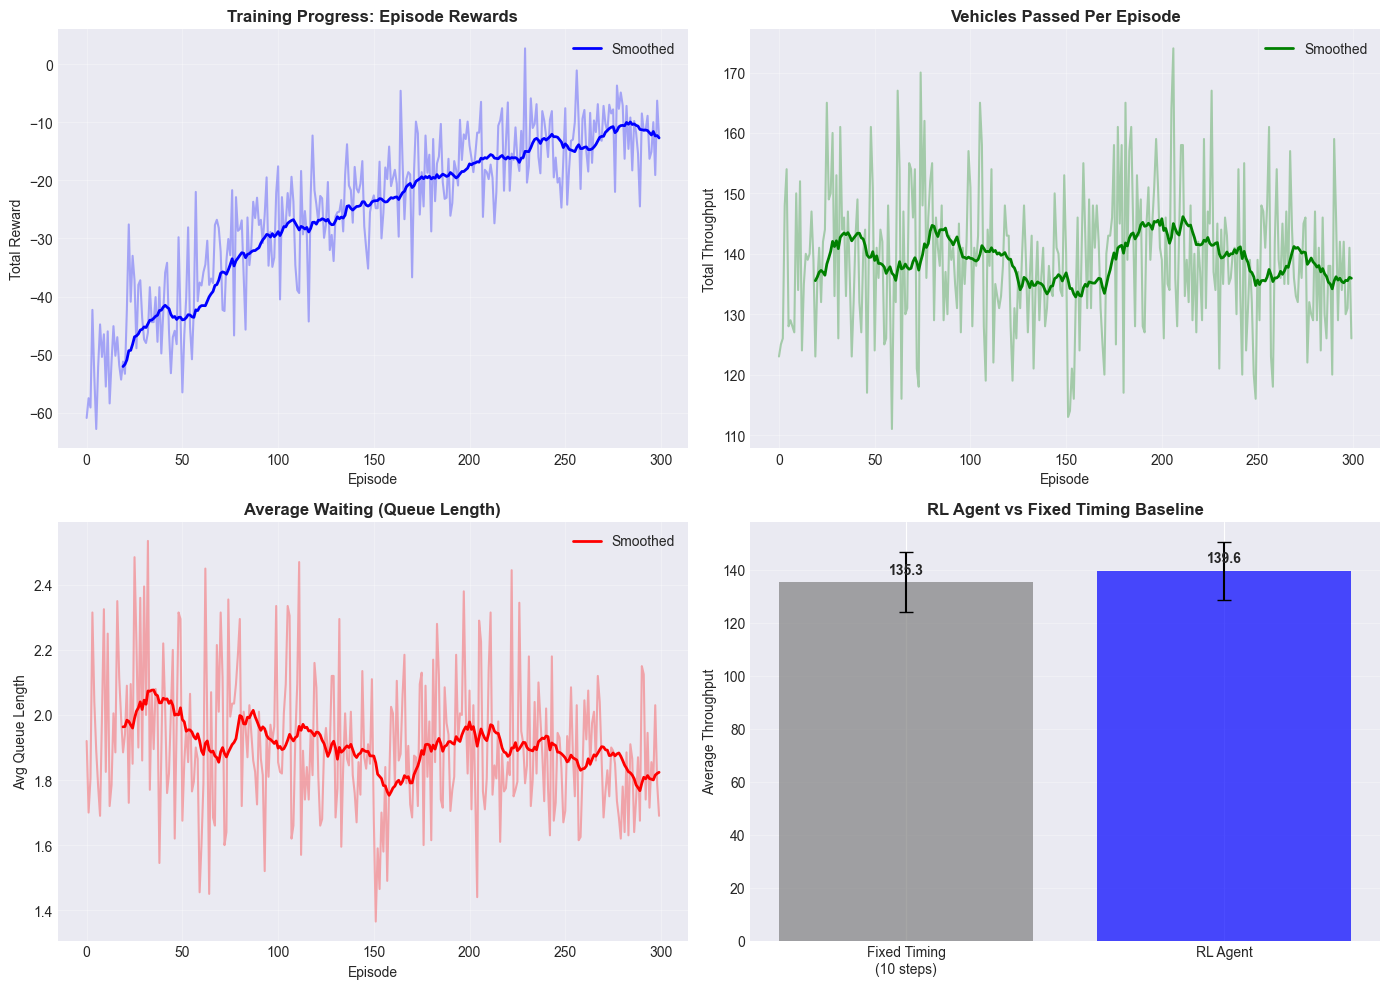


📊 Results Summary:
   Fixed Timing Throughput: 135.3 ± 11.5
   RL Agent Throughput:     139.6 ± 10.9
   Improvement: +3.1%


In [113]:
# Visualize training progress and compare with baseline
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Episode rewards
ax1 = axes[0, 0]
window = 20
smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax1.plot(episode_rewards, alpha=0.3, color='blue')
ax1.plot(range(window-1, len(episode_rewards)), smoothed_rewards, 
         color='blue', linewidth=2, label='Smoothed')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Progress: Episode Rewards', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Throughput over episodes
ax2 = axes[0, 1]
smoothed_throughput = np.convolve(episode_throughputs, np.ones(window)/window, mode='valid')
ax2.plot(episode_throughputs, alpha=0.3, color='green')
ax2.plot(range(window-1, len(episode_throughputs)), smoothed_throughput,
         color='green', linewidth=2, label='Smoothed')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Total Throughput')
ax2.set_title('Vehicles Passed Per Episode', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Average waiting time
ax3 = axes[1, 0]
smoothed_waiting = np.convolve(episode_waiting, np.ones(window)/window, mode='valid')
ax3.plot(episode_waiting, alpha=0.3, color='red')
ax3.plot(range(window-1, len(episode_waiting)), smoothed_waiting,
         color='red', linewidth=2, label='Smoothed')
ax3.set_xlabel('Episode')
ax3.set_ylabel('Avg Queue Length')
ax3.set_title('Average Waiting (Queue Length)', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Compare RL agent vs Fixed timing baseline
ax4 = axes[1, 1]

# Run comparison
def run_fixed_timing(env, phase_duration=10, n_episodes=50):
    """Baseline: Fixed timing controller."""
    throughputs = []
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        step = 0
        while not done:
            # Switch every phase_duration steps
            action = 1 if (step % phase_duration == phase_duration - 1) else 0
            state, _, done, info = env.step(action)
            step += 1
        throughputs.append(info['throughput'])
    return throughputs

def run_rl_agent(env, agent, n_episodes=50):
    """Run trained RL agent."""
    throughputs = []
    for _ in range(n_episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.get_action(state, training=False)
            state, _, done, info = env.step(action)
        throughputs.append(info['throughput'])
    return throughputs

np.random.seed(123)
fixed_throughputs = run_fixed_timing(env, phase_duration=10, n_episodes=50)
rl_throughputs = run_rl_agent(env, agent, n_episodes=50)

methods = ['Fixed Timing\n(10 steps)', 'RL Agent']
means = [np.mean(fixed_throughputs), np.mean(rl_throughputs)]
stds = [np.std(fixed_throughputs), np.std(rl_throughputs)]

bars = ax4.bar(methods, means, yerr=stds, capsize=5, color=['gray', 'blue'], alpha=0.7)
ax4.set_ylabel('Average Throughput')
ax4.set_title('RL Agent vs Fixed Timing Baseline', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, mean in zip(bars, means):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

improvement = (np.mean(rl_throughputs) - np.mean(fixed_throughputs)) / np.mean(fixed_throughputs) * 100
print(f"\n📊 Results Summary:")
print(f"   Fixed Timing Throughput: {np.mean(fixed_throughputs):.1f} ± {np.std(fixed_throughputs):.1f}")
print(f"   RL Agent Throughput:     {np.mean(rl_throughputs):.1f} ± {np.std(rl_throughputs):.1f}")
print(f"   Improvement: {improvement:+.1f}%")

<a id='robotics'></a>
### Robotics

**Considerations for Real-World Robotics**

Applying RL to robotics presents unique challenges that don't exist in simulated environments:

**Key Challenges:**

1. **Sample Efficiency**: Real robots are slow and expensive to operate
   - Each interaction takes real time (can't speed up physics)
   - Hardware wear and potential damage
   - Need algorithms that learn from fewer samples

2. **Safety Constraints**: Actions have real consequences
   - Can't explore dangerous actions freely
   - Need safe exploration strategies
   - Must handle hardware limits (joint angles, velocities)

3. **Continuous State/Action Spaces**: Physical systems are continuous
   - Joint angles, velocities, torques are continuous
   - Requires function approximation
   - Discretization loses precision

4. **Partial Observability**: Sensors don't capture everything
   - Noisy sensor readings
   - Occluded objects
   - Unobservable internal states

**Sim-to-Real Transfer:**

A common approach is to train in simulation and transfer to real robots:

| Simulation Advantages | Transfer Challenges |
|----------------------|--------------------|
| Fast data collection | Reality gap |
| Safe exploration | Sensor differences |
| Parallelizable | Actuator dynamics |
| Reproducible | Environmental factors |

**Techniques for Sim-to-Real:**
- **Domain Randomization**: Vary simulation parameters to cover real-world variations
- **System Identification**: Calibrate simulation to match real robot
- **Progressive Training**: Fine-tune on real robot after simulation training
- **Robust Policies**: Train policies that work across parameter ranges

In [114]:
# Simple 2D Robotic Arm Environment
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrow
from matplotlib.collections import PatchCollection

class SimpleRoboticArm:
    """
    A simple 2-link planar robotic arm environment.
    
    The arm must reach a target position by controlling joint angles.
    This demonstrates basic robotic control with continuous states/actions.
    """
    
    def __init__(self, link_lengths=(1.0, 0.8)):
        """
        Args:
            link_lengths: (L1, L2) lengths of the two arm links
        """
        self.L1, self.L2 = link_lengths
        self.max_angle_change = 0.1  # Max radians per step
        self.target_threshold = 0.1  # Distance to consider target reached
        
        self.reset()
    
    def reset(self, target=None):
        """Reset arm to initial position and set new target."""
        # Start with arm pointing right
        self.theta1 = 0.0  # First joint angle
        self.theta2 = 0.0  # Second joint angle
        
        # Random target within reachable workspace
        if target is None:
            # Generate random target in reachable area
            max_reach = self.L1 + self.L2
            min_reach = abs(self.L1 - self.L2)
            r = np.random.uniform(min_reach + 0.1, max_reach - 0.1)
            angle = np.random.uniform(-np.pi, np.pi)
            self.target = np.array([r * np.cos(angle), r * np.sin(angle)])
        else:
            self.target = np.array(target)
        
        self.steps = 0
        self.max_steps = 200
        
        return self._get_state()
    
    def _forward_kinematics(self):
        """Calculate end-effector position from joint angles."""
        # Position of first joint (elbow)
        x1 = self.L1 * np.cos(self.theta1)
        y1 = self.L1 * np.sin(self.theta1)
        
        # Position of end-effector
        x2 = x1 + self.L2 * np.cos(self.theta1 + self.theta2)
        y2 = y1 + self.L2 * np.sin(self.theta1 + self.theta2)
        
        return np.array([x1, y1]), np.array([x2, y2])
    
    def _get_state(self):
        """Return current state."""
        _, end_effector = self._forward_kinematics()
        
        # State: [joint angles, end-effector pos, target pos, distance to target]
        distance = np.linalg.norm(end_effector - self.target)
        
        return np.array([
            np.sin(self.theta1), np.cos(self.theta1),
            np.sin(self.theta2), np.cos(self.theta2),
            end_effector[0], end_effector[1],
            self.target[0], self.target[1],
            distance
        ], dtype=np.float32)
    
    def step(self, action):
        """
        Execute action and return new state.
        
        Args:
            action: [delta_theta1, delta_theta2] - changes to joint angles
                   Values should be in [-1, 1], scaled by max_angle_change
        """
        self.steps += 1
        
        # Apply action (clip to valid range)
        action = np.clip(action, -1, 1)
        self.theta1 += action[0] * self.max_angle_change
        self.theta2 += action[1] * self.max_angle_change
        
        # Keep angles in [-pi, pi]
        self.theta1 = np.arctan2(np.sin(self.theta1), np.cos(self.theta1))
        self.theta2 = np.arctan2(np.sin(self.theta2), np.cos(self.theta2))
        
        # Calculate reward
        _, end_effector = self._forward_kinematics()
        distance = np.linalg.norm(end_effector - self.target)
        
        # Reward: negative distance (closer is better)
        reward = -distance
        
        # Bonus for reaching target
        if distance < self.target_threshold:
            reward += 10.0
            done = True
        elif self.steps >= self.max_steps:
            done = True
        else:
            done = False
        
        info = {
            'distance': distance,
            'end_effector': end_effector,
            'reached': distance < self.target_threshold
        }
        
        return self._get_state(), reward, done, info
    
    def render(self, ax=None):
        """Visualize the arm and target."""
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
        
        elbow, end_effector = self._forward_kinematics()
        
        # Draw arm links
        ax.plot([0, elbow[0]], [0, elbow[1]], 'b-', linewidth=4, label='Link 1')
        ax.plot([elbow[0], end_effector[0]], [elbow[1], end_effector[1]], 
                'g-', linewidth=4, label='Link 2')
        
        # Draw joints
        ax.plot(0, 0, 'ko', markersize=10)  # Base
        ax.plot(elbow[0], elbow[1], 'bo', markersize=8)  # Elbow
        ax.plot(end_effector[0], end_effector[1], 'go', markersize=8)  # End-effector
        
        # Draw target
        ax.plot(self.target[0], self.target[1], 'r*', markersize=15, label='Target')
        
        # Draw workspace boundary
        theta = np.linspace(0, 2*np.pi, 100)
        max_reach = self.L1 + self.L2
        ax.plot(max_reach * np.cos(theta), max_reach * np.sin(theta), 
                'k--', alpha=0.3, label='Workspace')
        
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_aspect('equal')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
        ax.set_title('2-Link Robotic Arm')
        
        return ax


print("Robotic Arm Environment created!")
print("\nFeatures:")
print("  - 2-link planar arm with continuous joint angles")
print("  - Goal: reach target position")
print("  - State: joint angles, end-effector position, target, distance")
print("  - Action: joint angle changes (continuous)")

Robotic Arm Environment created!

Features:
  - 2-link planar arm with continuous joint angles
  - Goal: reach target position
  - State: joint angles, end-effector position, target, distance
  - Action: joint angle changes (continuous)


In [115]:
# Simple Policy Gradient Agent for Robotic Arm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

class RoboticArmPolicy(nn.Module):
    """Neural network policy for continuous control."""
    
    def __init__(self, state_dim=9, action_dim=2, hidden_dim=64):
        super().__init__()
        
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        
        # Output mean and log_std for each action dimension
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
    
    def forward(self, state):
        """Return action distribution parameters."""
        x = self.shared(state)
        mean = torch.tanh(self.mean_head(x))  # Actions in [-1, 1]
        std = torch.exp(self.log_std)
        return mean, std
    
    def get_action(self, state, deterministic=False):
        """Sample action from policy."""
        state = torch.FloatTensor(state).unsqueeze(0)
        mean, std = self.forward(state)
        
        if deterministic:
            return mean.squeeze(0).detach().numpy()
        
        dist = Normal(mean, std)
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        
        return action.squeeze(0).detach().numpy(), log_prob


def train_robotic_arm(env, policy, n_episodes=500, lr=0.001, gamma=0.99):
    """Train policy using REINFORCE."""
    optimizer = optim.Adam(policy.parameters(), lr=lr)
    
    episode_rewards = []
    success_rate = []
    
    for episode in range(n_episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        while not done:
            action, log_prob = policy.get_action(state)
            next_state, reward, done, info = env.step(action)
            
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
        
        # Calculate returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.FloatTensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        # Policy gradient update
        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        
        optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        optimizer.step()
        
        episode_rewards.append(sum(rewards))
        success_rate.append(1 if info['reached'] else 0)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_success = np.mean(success_rate[-100:]) * 100
            print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:7.1f} | "
                  f"Success Rate: {avg_success:.1f}%")
    
    return episode_rewards, success_rate


# Train the robotic arm agent
np.random.seed(42)
torch.manual_seed(42)

env = SimpleRoboticArm()
policy = RoboticArmPolicy()

print("Training Robotic Arm Policy...")
print("="*50)

episode_rewards, success_rate = train_robotic_arm(env, policy, n_episodes=500)

print("\nTraining complete!")

Training Robotic Arm Policy...
Episode 100 | Avg Reward:  -335.9 | Success Rate: 6.0%
Episode 200 | Avg Reward:  -288.3 | Success Rate: 10.0%
Episode 300 | Avg Reward:  -295.9 | Success Rate: 7.0%
Episode 400 | Avg Reward:  -271.9 | Success Rate: 12.0%
Episode 500 | Avg Reward:  -233.4 | Success Rate: 14.0%

Training complete!


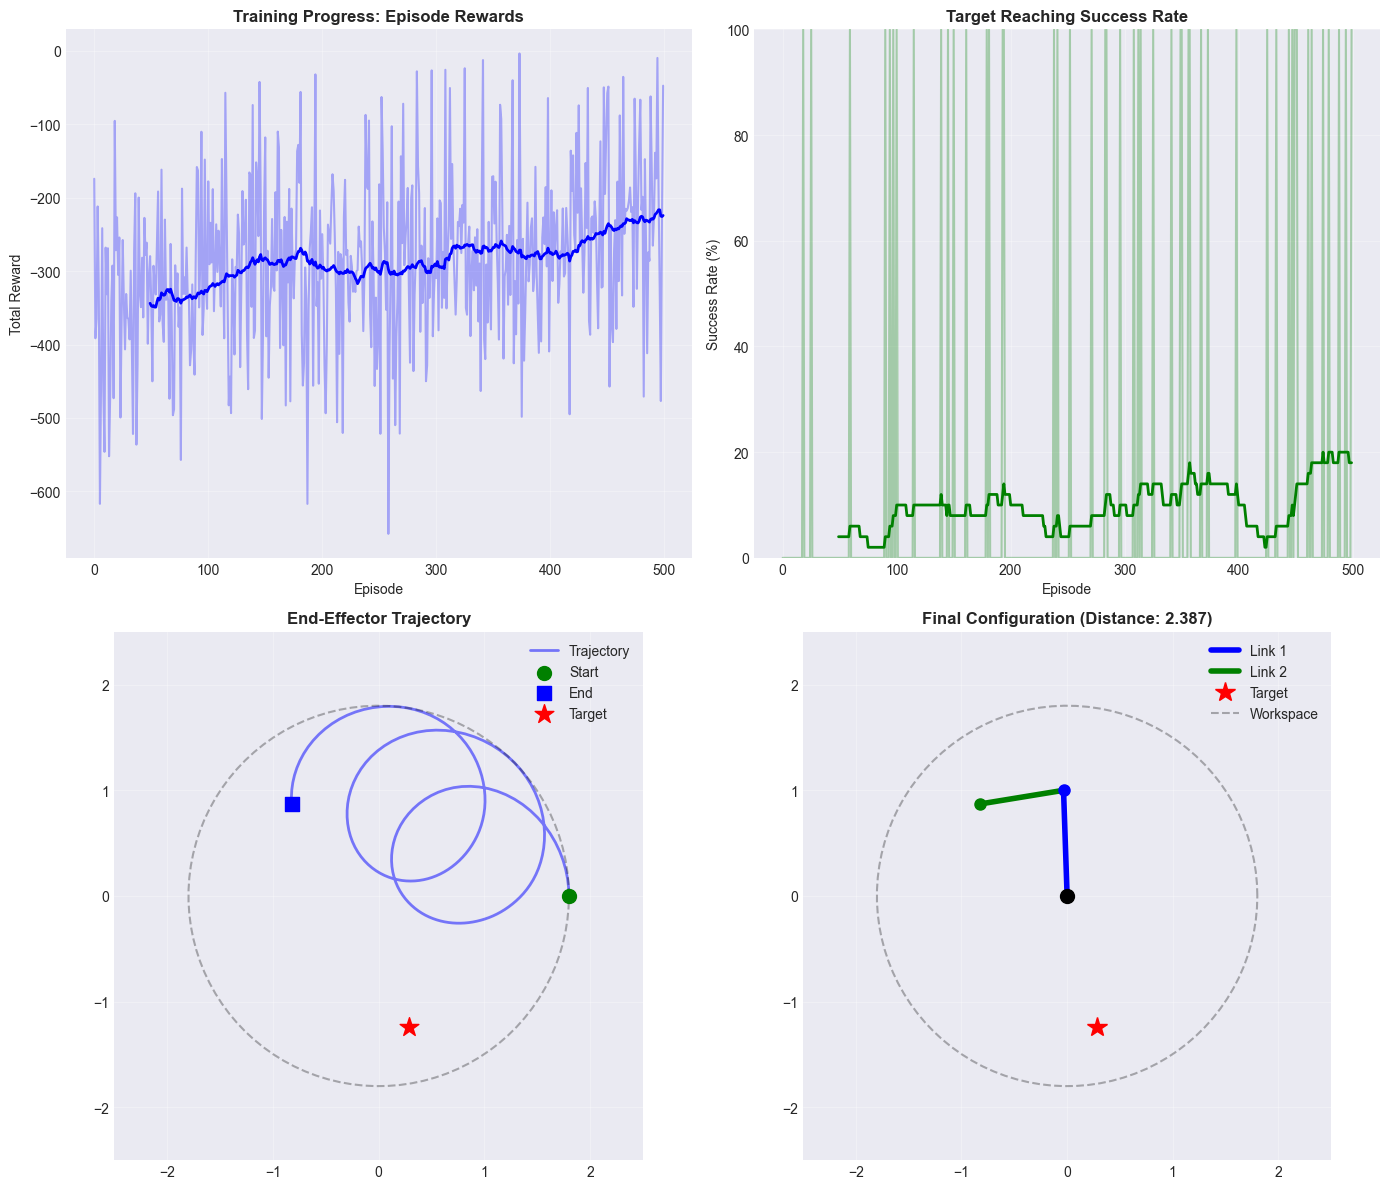


📊 Testing on 20 random targets:
   Success Rate: 20%
   Average Final Distance: 1.001
   Min Distance: 0.072
   Max Distance: 2.643


In [116]:
# Visualize training and demonstrate learned policy
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Training rewards
ax1 = axes[0, 0]
window = 50
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax1.plot(episode_rewards, alpha=0.3, color='blue')
ax1.plot(range(window-1, len(episode_rewards)), smoothed, color='blue', linewidth=2)
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Progress: Episode Rewards', fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Success rate
ax2 = axes[0, 1]
smoothed_success = np.convolve(success_rate, np.ones(window)/window, mode='valid')
ax2.plot(np.array(success_rate) * 100, alpha=0.3, color='green')
ax2.plot(range(window-1, len(success_rate)), smoothed_success * 100, 
         color='green', linewidth=2)
ax2.set_xlabel('Episode')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('Target Reaching Success Rate', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])

# Plot 3: Demonstrate learned policy - trajectory
ax3 = axes[1, 0]
np.random.seed(123)
state = env.reset()
trajectory = [env._forward_kinematics()[1].copy()]

done = False
while not done:
    action = policy.get_action(state, deterministic=True)
    state, _, done, info = env.step(action)
    trajectory.append(env._forward_kinematics()[1].copy())

trajectory = np.array(trajectory)
ax3.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.5, linewidth=2, label='Trajectory')
ax3.scatter(trajectory[0, 0], trajectory[0, 1], c='green', s=100, marker='o', label='Start', zorder=5)
ax3.scatter(trajectory[-1, 0], trajectory[-1, 1], c='blue', s=100, marker='s', label='End', zorder=5)
ax3.scatter(env.target[0], env.target[1], c='red', s=200, marker='*', label='Target', zorder=5)

# Draw workspace
theta = np.linspace(0, 2*np.pi, 100)
max_reach = env.L1 + env.L2
ax3.plot(max_reach * np.cos(theta), max_reach * np.sin(theta), 'k--', alpha=0.3)

ax3.set_xlim(-2.5, 2.5)
ax3.set_ylim(-2.5, 2.5)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_title('End-Effector Trajectory', fontweight='bold')

# Plot 4: Final arm configuration
ax4 = axes[1, 1]
env.render(ax4)
ax4.set_title(f'Final Configuration (Distance: {info["distance"]:.3f})', fontweight='bold')

plt.tight_layout()
plt.show()

# Test on multiple targets
print("\n📊 Testing on 20 random targets:")
successes = 0
distances = []

for i in range(20):
    state = env.reset()
    done = False
    while not done:
        action = policy.get_action(state, deterministic=True)
        state, _, done, info = env.step(action)
    
    distances.append(info['distance'])
    if info['reached']:
        successes += 1

print(f"   Success Rate: {successes/20*100:.0f}%")
print(f"   Average Final Distance: {np.mean(distances):.3f}")
print(f"   Min Distance: {np.min(distances):.3f}")
print(f"   Max Distance: {np.max(distances):.3f}")

<a id='trading'></a>
### Autonomous Trading

**Trading as an RL Problem**

Financial trading is a natural fit for reinforcement learning:

- **Sequential Decisions**: Buy, sell, or hold decisions over time
- **Uncertain Environment**: Market dynamics are complex and partially observable
- **Clear Rewards**: Profit/loss provides direct feedback
- **Exploration vs Exploitation**: Balance trying new strategies vs using proven ones

**MDP Formulation for Trading:**

**State Space:**
- Current portfolio holdings
- Cash balance
- Price history (recent prices, moving averages)
- Technical indicators (RSI, MACD, etc.)
- Market features (volume, volatility)

**Action Space:**
- Discrete: {Buy, Sell, Hold}
- Continuous: Position size (-1 to +1 representing short to long)

**Reward Design Considerations:**

| Reward Type | Pros | Cons |
|-------------|------|------|
| Raw P&L | Direct, interpretable | High variance, sparse |
| Sharpe Ratio | Risk-adjusted | Requires window of returns |
| Log Returns | Handles compounding | Can be unstable |
| Risk-Adjusted P&L | Balances risk/reward | Requires risk model |

**Risk Management:**
- Position limits (max exposure)
- Stop-loss mechanisms
- Drawdown constraints
- Transaction cost modeling

In [117]:
# Simple Trading Environment
import numpy as np
import matplotlib.pyplot as plt

class SimpleTradingEnv:
    """
    A simplified trading environment for a single asset.
    
    Features:
    - Simulated price series with trend and noise
    - Transaction costs
    - Position tracking
    - Risk-adjusted rewards
    """
    
    def __init__(self, n_steps=252, initial_cash=10000, transaction_cost=0.001):
        """
        Args:
            n_steps: Number of trading days
            initial_cash: Starting capital
            transaction_cost: Cost per trade as fraction of trade value
        """
        self.n_steps = n_steps
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.lookback = 10  # Days of price history in state
        
        self.reset()
    
    def _generate_prices(self):
        """Generate synthetic price series with realistic properties."""
        # Geometric Brownian Motion with mean reversion
        dt = 1/252  # Daily
        mu = 0.1    # Annual drift
        sigma = 0.2  # Annual volatility
        
        prices = [100.0]  # Starting price
        for _ in range(self.n_steps + self.lookback):
            # Add some mean reversion
            mean_price = 100
            reversion = 0.01 * (mean_price - prices[-1])
            
            # Random walk with drift
            drift = (mu - 0.5 * sigma**2) * dt + reversion
            diffusion = sigma * np.sqrt(dt) * np.random.randn()
            
            new_price = prices[-1] * np.exp(drift + diffusion)
            prices.append(new_price)
        
        return np.array(prices)
    
    def reset(self):
        """Reset the environment."""
        self.prices = self._generate_prices()
        self.current_step = self.lookback
        self.cash = self.initial_cash
        self.shares = 0
        self.portfolio_values = [self.initial_cash]
        
        return self._get_state()
    
    def _get_state(self):
        """Return current state."""
        # Price features
        recent_prices = self.prices[self.current_step - self.lookback:self.current_step + 1]
        normalized_prices = recent_prices / recent_prices[0] - 1  # Returns from lookback start
        
        # Technical indicators
        current_price = self.prices[self.current_step]
        sma_5 = np.mean(self.prices[self.current_step-4:self.current_step+1])
        sma_10 = np.mean(self.prices[self.current_step-9:self.current_step+1])
        
        # Position info
        portfolio_value = self.cash + self.shares * current_price
        position_ratio = (self.shares * current_price) / portfolio_value if portfolio_value > 0 else 0
        
        state = np.concatenate([
            normalized_prices,
            [current_price / 100 - 1],  # Normalized current price
            [(sma_5 - current_price) / current_price],  # Price vs SMA5
            [(sma_10 - current_price) / current_price],  # Price vs SMA10
            [position_ratio],  # Current position
            [self.cash / self.initial_cash]  # Normalized cash
        ])
        
        return state.astype(np.float32)
    
    def step(self, action):
        """
        Execute trading action.
        
        Args:
            action: 0 = Sell, 1 = Hold, 2 = Buy
            
        Returns:
            state, reward, done, info
        """
        current_price = self.prices[self.current_step]
        old_portfolio_value = self.cash + self.shares * current_price
        
        # Execute action
        if action == 0:  # Sell
            if self.shares > 0:
                sell_value = self.shares * current_price
                cost = sell_value * self.transaction_cost
                self.cash += sell_value - cost
                self.shares = 0
        elif action == 2:  # Buy
            if self.cash > 0:
                # Buy as many shares as possible
                max_shares = self.cash / (current_price * (1 + self.transaction_cost))
                shares_to_buy = int(max_shares)
                if shares_to_buy > 0:
                    cost = shares_to_buy * current_price * (1 + self.transaction_cost)
                    self.cash -= cost
                    self.shares += shares_to_buy
        # action == 1: Hold - do nothing
        
        # Move to next day
        self.current_step += 1
        new_price = self.prices[self.current_step]
        new_portfolio_value = self.cash + self.shares * new_price
        
        self.portfolio_values.append(new_portfolio_value)
        
        # Calculate reward (daily return)
        daily_return = (new_portfolio_value - old_portfolio_value) / old_portfolio_value
        
        # Risk-adjusted reward (penalize large drawdowns)
        max_value = max(self.portfolio_values)
        drawdown = (max_value - new_portfolio_value) / max_value
        reward = daily_return - 0.5 * drawdown  # Penalize drawdowns
        
        done = self.current_step >= self.n_steps + self.lookback - 1
        
        info = {
            'portfolio_value': new_portfolio_value,
            'cash': self.cash,
            'shares': self.shares,
            'price': new_price,
            'daily_return': daily_return,
            'total_return': (new_portfolio_value - self.initial_cash) / self.initial_cash
        }
        
        return self._get_state(), reward, done, info


class TradingQLearningAgent:
    """Q-Learning agent for trading."""
    
    def __init__(self, state_dim, n_actions=3, lr=0.1, gamma=0.95, epsilon=1.0):
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        
        self.q_table = {}
    
    def _discretize_state(self, state):
        """Discretize continuous state."""
        # Use key features for discretization
        bins = [-0.1, -0.05, -0.02, 0, 0.02, 0.05, 0.1]
        
        # Discretize recent return (last element of price history)
        recent_return = state[10]  # Normalized current price
        price_bin = np.digitize(recent_return, bins)
        
        # Discretize position
        position = state[-2]
        pos_bin = 0 if position < 0.3 else (1 if position < 0.7 else 2)
        
        # Discretize trend (SMA comparison)
        trend = state[12]  # Price vs SMA5
        trend_bin = 0 if trend < -0.02 else (1 if trend < 0.02 else 2)
        
        return (price_bin, pos_bin, trend_bin)
    
    def get_action(self, state, training=True):
        """Select action using epsilon-greedy."""
        if training and np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        
        discrete_state = self._discretize_state(state)
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.n_actions)
        
        return np.argmax(self.q_table[discrete_state])
    
    def update(self, state, action, reward, next_state, done):
        """Update Q-values."""
        discrete_state = self._discretize_state(state)
        discrete_next = self._discretize_state(next_state)
        
        if discrete_state not in self.q_table:
            self.q_table[discrete_state] = np.zeros(self.n_actions)
        if discrete_next not in self.q_table:
            self.q_table[discrete_next] = np.zeros(self.n_actions)
        
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.max(self.q_table[discrete_next])
        
        self.q_table[discrete_state][action] += self.lr * (
            target - self.q_table[discrete_state][action]
        )
        
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


print("Trading Environment created!")
print("\nFeatures:")
print("  - Simulated price series with realistic dynamics")
print("  - Transaction costs modeled")
print("  - State includes price history and technical indicators")
print("  - Actions: Buy, Hold, Sell")

Trading Environment created!

Features:
  - Simulated price series with realistic dynamics
  - Transaction costs modeled
  - State includes price history and technical indicators
  - Actions: Buy, Hold, Sell
